# 5. Single-molecule data analysis 2

In [1]:
from pathlib2 import Path
import papylio as pp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

## Experiment import
Note that the sequencing data is automatically imported.

In [2]:
experiment_path = Path(r'C:\Users\user\Desktop\SPARXS example dataset')

In [3]:
data_per_sequence_path = experiment_path / 'Analysis' / 'Datasets per sequence'
data_per_sequence_path

WindowsPath('C:/Users/user/Desktop/SPARXS example dataset/Analysis/Datasets per sequence')

In [4]:
exp = pp.Experiment(data_per_sequence_path)

Import files: 100%|█████████████████████████████████████████████████████████████| 7948/7948 [00:00<00:00, 46126.39it/s]



Initialize experiment: 
C:\Users\user\Desktop\SPARXS example dataset\Analysis\Datasets per sequence


In [5]:
exp.files[0:10]

FileCollection([File(AAAAAGCG),
                File(AAAAAGTT),
                File(AAACAAAA),
                File(AAAGCATC),
                File(AAAGGAGT),
                File(AAATCGCT),
                File(AAATCTAT),
                File(AAATTCGG),
                File(AAATTGCG),
                File(AACAACGT)])

In [6]:
file_HJ1 = exp.files.select('TTAGCCGA', 'name')[0]
file_HJ3 = exp.files.select('AATCGGCT', 'name')[0]
file_HJ7 = exp.files.select('GGCGCCGC', 'name')[0]
files_HJ137 = exp.files.select('TTAGCCGA|AATCGGCT|GGCGCCGC', 'name')

## Molecule selection (or filtering)

### Determine intensity thresholds
The thresholds are generally best determined from the data originating from all sequences, as opposed to some example sequences.

For the Holliday junction dataset we selected molecules for which the Cy5 acceptor was active both before and after imaging with the green laser. In this way we did not have to take acceptor bleaching into account. Additionally, we selected molecules with total intensity (Cy3 + Cy5) upon green laser excitation, to be in the single-molecule range, i.e. above background and without other molecules present. Hence, we needed to determine three thresholds, a lower treshold for Cy5 and an lower and upper threshold for the total intensity.

Cy5 intensity before imaging with green laser

In [7]:
intensity_red_before = exp.files.intensity_red_before.sel(channel=1)

100%|██████████████████████████████████████████████████████████████████████████████| 7948/7948 [01:19<00:00, 99.92it/s]


Text(0.5, 1.0, 'hist_intensity_red_before')

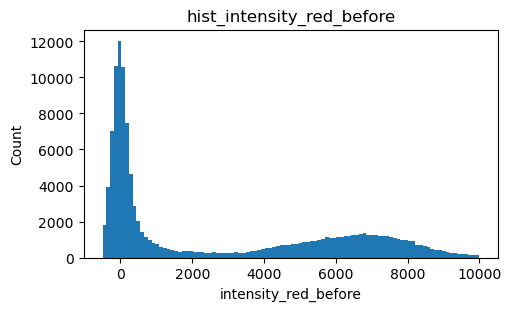

In [8]:
fig, ax = plt.subplots(figsize=(5, 3), layout='constrained')
intensity_red_before.plot.hist(bins=100, ax=ax, range=(-500,10000))
ax.set_ylabel('Count')
title = 'hist_intensity_red_before'
ax.set_title(title)

Cy5 intensity after imaging with the green laser

In [9]:
intensity_red_after = exp.files.intensity_red_after.sel(channel=1)

100%|█████████████████████████████████████████████████████████████████████████████| 7948/7948 [01:10<00:00, 112.68it/s]


Text(0.5, 1.0, 'hist_intensity_red_after')

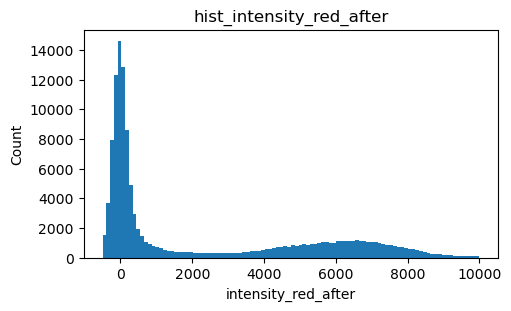

In [10]:
fig, ax = plt.subplots(figsize=(5, 3), layout='constrained')
intensity_red_after.plot.hist(bins=100, ax=ax, range=(-500,10000))
ax.set_ylabel('Count')
title = 'hist_intensity_red_after'
ax.set_title(title)

Total intensity

In [11]:
intensity = exp.files.intensity

100%|█████████████████████████████████████████████████████████████████████████████| 7948/7948 [01:13<00:00, 108.72it/s]


In [12]:
intensity_total_start = intensity.sel(frame=np.arange(5,10)).sum('channel').mean('frame')

Intensity range 3 sigma 5665.467330207128 29523.580994683183


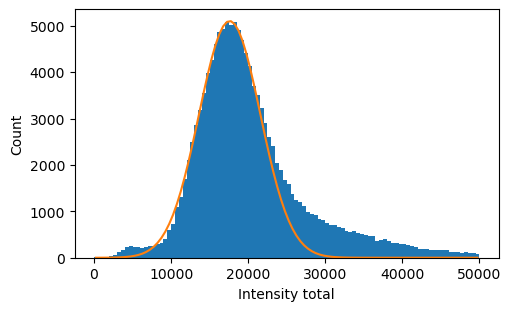

In [13]:
fig, ax = plt.subplots(figsize=(5, 3), layout='constrained')
c, x, _ = intensity_total_start.plot.hist(bins=100, ax=ax, range=(0,50000))# ,histtype='step')

x_center = (x[1:] + x[:-1])/2

def gaussian(x, A, mu, sig):
    return A * np.exp(-(x-mu)**2 / (2 * sig **2))

selection = (x_center>11000) & (x_center<20000)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(gaussian, x_center[selection], c[selection], p0=(np.max(c), np.mean(x_center), np.mean(x_center)))

ax.plot(x_center, gaussian(x_center, *popt))

ax.set_xlabel('Intensity total')
ax.set_ylabel('Count')

A, mu, sig = popt
sig = np.abs(sig)

print('Intensity range 3 sigma', mu - 3 * sig, mu + 3 * sig)

# title = 'Intensity range 3 sigma'
# fig.savefig(save_path / (title + '.png'))
# fig.savefig(save_path / (title + '.pdf'))

Finally, we selected the following tresholds.

In [14]:
red_intensity_cutoff = 2000
intensity_total_min = 9000
intensity_total_max = 30000

### Define selections
As an example we perform this on HJ7 file.

In [15]:
file = file_HJ7

In [16]:
selection_Cy5_active_start = file.intensity_red_before.sel(channel=1, drop=True) > red_intensity_cutoff
selection_Cy5_active_start.name = 'selection_Cy5_active_start'
selection_Cy5_active_start

<xarray.DataArray 'selection_Cy5_active_start' (molecule: 753)>
array([False, False,  True,  True,  True, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
        True, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
        True, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
       False,  True,  True, False,  True, False, False, False, False,
        True, False, False, False, False,  True,  True, False,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
       False, False, False,  True,  True, False, False,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True, False, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False, False, False, False,  True,  True, False, False,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False,  True,  True,  True, False,
...
       False,  True,  True,  True, False, False,  True, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False, False,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True, False, False,
        True, False, False, False, False, False,  True, False,  True,
        True,  True, False, False, False,  True,  True, False,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True,  True,  True, False, False, False,  True, False,
        True,  True, False, False, False,  True,  True, False,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False, False, False, False, False,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True, False])
Coordinates:
    molecule_in_file  (molecule) int32 999 719 141 70 1113 ... 508 848 1340 352
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
    sequence_in_file  (molecule) int32 386 412 949 970 1532 ... 131 160 758 670
Dimensions without coordinates: molecule

In [17]:
selection_Cy5_active_end = file.intensity_red_after.sel(channel=1, drop=True) > red_intensity_cutoff
selection_Cy5_active_end.name = 'selection_Cy5_active_end'
selection_Cy5_active_end

<xarray.DataArray 'selection_Cy5_active_end' (molecule: 753)>
array([False, False,  True,  True,  True, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False, False, False,  True,  True, False, False,  True, False,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
       False,  True,  True, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False,  True,
       False, False,  True,  True, False,  True, False,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
       False, False, False,  True, False, False, False,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False, False, False,  True, False,  True, False, False,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False,  True,  True,  True, False,
...
       False,  True,  True,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True,  True,
        True,  True, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
       False,  True,  True, False,  True,  True, False, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False,  True,
        True,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False,  True,  True, False,
       False,  True,  True,  True, False, False, False, False, False,
        True,  True, False, False, False,  True,  True, False,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False, False, False, False, False,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True, False])
Coordinates:
    molecule_in_file  (molecule) int32 999 719 141 70 1113 ... 508 848 1340 352
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
    sequence_in_file  (molecule) int32 386 412 949 970 1532 ... 131 160 758 670
Dimensions without coordinates: molecule

In [18]:
intensity_total_rolling = file.intensity_total.rolling(frame=5, center=True).mean().dropna('frame')
selection_intensity_total = (intensity_total_rolling < intensity_total_max).all('frame')
selection_intensity_total.name = 'selection_intensity_total'
selection_intensity_total

<xarray.DataArray 'selection_intensity_total' (molecule: 753)>
array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
...
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False, False,  True,  True,
        True,  True,  True, False,  True,  True, False,  True, False,
       False, False, False, False, False,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True,  True, False,
        True,  True, False,  True, False,  True])
Coordinates:
    molecule_in_file  (molecule) int32 999 719 141 70 1113 ... 508 848 1340 352
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
    sequence_in_file  (molecule) int32 386 412 949 970 1532 ... 131 160 758 670
Dimensions without coordinates: molecule

### Save and apply selections

In [19]:
file.selected

<xarray.DataArray 'selected' (molecule: 753)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])
Coordinates:
    molecule_in_file  (molecule) int32 999 719 141 70 1113 ... 508 848 1340 352
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
    sequence_in_file  (molecule) int32 386 412 949 970 1532 ... 131 160 758 670
Dimensions without coordinates: molecule

In [20]:
file.set_variable(selection_Cy5_active_start)
file.set_variable(selection_Cy5_active_end)
file.set_variable(selection_intensity_total)

The selection are now stored in the dataset for this sequence, starting with `selection_`:

In [21]:
file.dataset

<xarray.Dataset>
Dimensions:                     (molecule: 753, channel: 2, dimension: 2,
                                 frame: 400)
Coordinates:
    molecule_in_file            (molecule) int32 999 719 141 70 ... 848 1340 352
    file                        (molecule) |S58 b'Single-molecule data - gree...
  * channel                     (channel) int64 0 1
  * dimension                   (dimension) |S1 b'x' b'y'
    time                        (frame) float64 0.0 0.123 0.245 ... 48.75 48.87
  * frame                       (frame) int32 0 1 2 3 4 ... 395 396 397 398 399
    illumination                (frame) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    sequence_in_file            (molecule) int32 386 412 949 970 ... 160 758 670
Dimensions without coordinates: molecule
Data variables: (12/19)
    selected                    (molecule) bool False False ... False False
    coordinates                 (molecule, channel, dimension) float64 24.92 ...
    intensity                   (molecule, channel, frame) float64 1.559e+04 ...
    intensity_raw               (molecule, channel, frame) float64 9.597e+03 ...
    FRET                        (molecule, frame) float64 0.0 0.0 ... 0.05922
    intensity_red_before        (molecule, channel) float64 5.718 ... -143.0
    ...                          ...
    sequence_subset             (molecule) |S8 b'GGCGCCGC' ... b'GGCGCCGC'
    sequence_quality_subset     (molecule) |S8 b'7EGG<B7>' ... b'6@8C7C@B'
    sequence_coordinates        (molecule, dimension) int64 6849 2670 ... 24880
    selection_Cy5_active_start  (molecule) bool False False True ... True False
    selection_Cy5_active_end    (molecule) bool False False True ... True False
    selection_intensity_total   (molecule) bool True True True ... False True

Applying the selections changes the `selected` dataarray in the dataset.

In [22]:
file.apply_selections(['selection_intensity_total', 'selection_Cy5_active_start', 'selection_Cy5_active_end'])

In [23]:
file.selected

<xarray.DataArray 'selected' (molecule: 753)>
array([False, False,  True, False,  True, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False,  True, False,  True,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False, False,  True,  True, False, False,  True, False,
        True,  True, False, False,  True, False,  True, False,  True,
        True,  True,  True, False,  True, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
       False, False,  True,  True, False,  True, False, False,  True,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False, False,  True, False, False, False,  True,  True,
        True, False,  True, False, False,  True,  True,  True, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True, False, False, False, False,  True,  True,  True,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False,  True,  True, False, False,
...
       False,  True,  True,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False,  True, False,
       False,  True,  True, False,  True,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False, False, False, False, False, False,
        True,  True, False, False, False,  True,  True, False,  True,
       False,  True,  True, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True, False, False])
Coordinates:
    molecule_in_file  (molecule) int32 999 719 141 70 1113 ... 508 848 1340 352
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
    sequence_in_file  (molecule) int32 386 412 949 970 1532 ... 131 160 758 670
Dimensions without coordinates: molecule
Attributes:
    selection_names:  ['selection_intensity_total', 'selection_Cy5_active_sta...

## Trace classification
Here we classify the traces of selected molecules, i.e. we determine the state at each time point of the trace.
First, we would like to exclude parts of the traces where the donor is inactive and where the total intensity is higher than the single-molecule threshold. Then we fit the remaining parts to one-state and two-state hidden Markov models (HMM) and determine which of the two fits best using the Bayesian nformation criterion (BIC).

### Define classifications
Determine where the donor is active.

In [24]:
from scipy.signal import medfilt

In [25]:
classification_donor_active = xr.DataArray(medfilt((file.intensity_total > intensity_total_min).astype(int), kernel_size=(1,11)).astype(bool),
                                           name='classification_donor_active', 
                                           dims=('molecule','frame'))
classification_donor_active            

<xarray.DataArray 'classification_donor_active' (molecule: 753, frame: 400)>
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Dimensions without coordinates: molecule, frame

Determin in which frames only a single dye is present.

In [26]:
classification_single_dye = xr.DataArray(medfilt((file.intensity_total < intensity_total_max).astype(int), kernel_size=(1,11)).astype(bool),
                                         name='classification_single_dye', 
                                         dims=('molecule','frame'))
classification_single_dye

<xarray.DataArray 'classification_single_dye' (molecule: 753, frame: 400)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])
Dimensions without coordinates: molecule, frame

### Save and apply classifications

In [27]:
file.set_variable(classification_donor_active)
file.set_variable(classification_single_dye)

The selection are now stored in the dataset for this sequence, starting with `classification_`:

In [28]:
file.dataset

<xarray.Dataset>
Dimensions:                      (molecule: 753, channel: 2, dimension: 2,
                                  frame: 400)
Coordinates:
    molecule_in_file             (molecule) int32 999 719 141 ... 848 1340 352
    file                         (molecule) |S58 b'Single-molecule data - gre...
  * channel                      (channel) int64 0 1
  * dimension                    (dimension) |S1 b'x' b'y'
    time                         (frame) float64 0.0 0.123 0.245 ... 48.75 48.87
  * frame                        (frame) int32 0 1 2 3 4 ... 395 396 397 398 399
    illumination                 (frame) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    sequence_in_file             (molecule) int32 386 412 949 ... 160 758 670
Dimensions without coordinates: molecule
Data variables: (12/21)
    selected                     (molecule) bool False False ... False False
    coordinates                  (molecule, channel, dimension) float64 24.92...
    intensity                    (molecule, channel, frame) float64 1.559e+04...
    intensity_raw                (molecule, channel, frame) float64 9.597e+03...
    FRET                         (molecule, frame) float64 0.0 0.0 ... 0.05922
    intensity_red_before         (molecule, channel) float64 5.718 ... -143.0
    ...                           ...
    sequence_coordinates         (molecule, dimension) int64 6849 2670 ... 24880
    selection_Cy5_active_start   (molecule) bool False False True ... True False
    selection_Cy5_active_end     (molecule) bool False False True ... True False
    selection_intensity_total    (molecule) bool True True True ... False True
    classification_donor_active  (molecule, frame) bool True True ... True True
    classification_single_dye    (molecule, frame) bool True True ... True True

Here we set inactive donor frames to state -1 and frames above the total intensity treshold to state -2. These are negative states, indicating exclusion in later analysis. Anything else is set to state 0.

Applying the selections changes the `classification` dataarray in the dataset.

In [29]:
file.apply_classifications(classification_donor_active=-1, classification_single_dye=-2)

In [30]:
file.classification

<xarray.DataArray 'classification' (molecule: 753, frame: 400)>
array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [-2, -2, -2, ..., -2, -2, -2],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8)
Coordinates:
    molecule_in_file  (molecule) int32 999 719 141 70 1113 ... 508 848 1340 352
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
    time              (frame) float64 0.0 0.123 0.245 ... 48.62 48.75 48.87
  * frame             (frame) int32 0 1 2 3 4 5 6 ... 394 395 396 397 398 399
    illumination      (frame) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    sequence_in_file  (molecule) int32 386 412 949 970 1532 ... 131 160 758 670
Dimensions without coordinates: molecule

### Hidden Markov modelling

In the `classify_hmm` method a one-state and two-state hidden Markov model are applied to each trace and one of the two models is automatically chosen based on the Bayesian information criterion. Here, only the regions with state 0 of selected traces are used.

In [31]:
file.classify_hmm('FRET')

  7%|█████▏                                                                          | 49/753 [00:00<00:01, 426.89it/s]

Serial processing


100%|███████████████████████████████████████████████████████████████████████████████| 753/753 [00:03<00:00, 205.62it/s]


In [32]:
file.classification_hmm

<xarray.DataArray 'classification_hmm' (molecule: 753, frame: 400)>
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)
Coordinates:
    molecule_in_file  (molecule) int32 999 719 141 70 1113 ... 508 848 1340 352
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
    time              (frame) float64 0.0 0.123 0.245 ... 48.62 48.75 48.87
  * frame             (frame) int32 0 1 2 3 4 5 6 ... 394 395 396 397 398 399
    illumination      (frame) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    sequence_in_file  (molecule) int32 386 412 949 970 1532 ... 131 160 758 670
Dimensions without coordinates: molecule

`classify_hmm` adds additional selections to the dataset:
- `selection_complex_rates` if the hmm fit produces complex-valued transition rates.
- `selection_lower_rate_limit` if the hmm fit produces transition rates that are slower than can be measured with the time resolution.

So we apply these selections to the overall selection.

In [33]:
# Apply additional selections produced by classify_hmm
file.apply_selections(['selection_intensity_total', 'selection_Cy5_active_start', 'selection_Cy5_active_end',
                       'selection_complex_rates', 'selection_lower_rate_limit'])

`classify_hmm` adds adds an additional classification to the dataset: `classification_hmm`. This is -1 in case the initial classification was negative, 0 in case of the low FRET state (or a single state) and 1 in case of the high FRET state.

We apply the classifications, using `classification_donor_active` and `classification_hmm` as before, but we add states 0 and 1 of `classification_hmm`.
We do not use the -1 classification in `classification_hmm`, indicated by `None`, because this is already included in states -2 and -1.

In [34]:
# Apply additional classification produced by classify_hmm
file.apply_classifications(classification_donor_active=-1, classification_single_dye=-2, classification_hmm=[None, 0, 1])

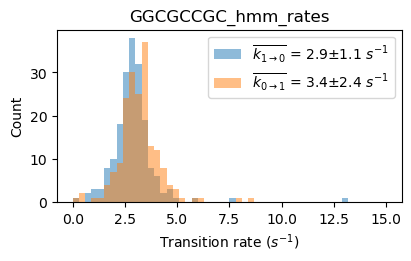

In [35]:
file.plot_hmm_rates()

## Evaluate traces

In [36]:
file.show_traces(plot_variables=['intensity_total', 'intensity', 'FRET', 'classification'], 
                 ylims=[(0, 35000), (0, 35000), (0, 1), (-2.5,1.5)], 
                 colours=[('k'), ('g', 'r'), ('b'), ('k')], selected=False, height=5)

%matplotlib inline

## Full pipeline

In [37]:
def pipeline(file, red_intensity_cutoff, intensity_total_min, intensity_total_max):
    try:
        # Define selections
        selection_Cy5_active_start = file.intensity_red_before.sel(channel=1, drop=True) > red_intensity_cutoff
        selection_Cy5_active_start.name = 'selection_Cy5_active_start'
        
        selection_Cy5_active_end = file.intensity_red_after.sel(channel=1, drop=True) > red_intensity_cutoff
        selection_Cy5_active_end.name = 'selection_Cy5_active_end'
        
        intensity_total_rolling = file.intensity_total.rolling(frame=5, center=True).mean().dropna('frame')
        selection_intensity_total = (intensity_total_rolling < intensity_total_max).all('frame')
        selection_intensity_total.name = 'selection_intensity_total'
    
        # Save selections
        file.set_variable(selection_Cy5_active_start)
        file.set_variable(selection_Cy5_active_end)
        file.set_variable(selection_intensity_total)
    
        # Apply selections
        file.apply_selections(['selection_intensity_total', 'selection_Cy5_active_start', 'selection_Cy5_active_end'])
    
        # Define classifictions
        classification_donor_active = xr.DataArray(medfilt((file.intensity_total > intensity_total_min).astype(int), kernel_size=(1,11)).astype(bool),
                                                   name='classification_donor_active', 
                                                   dims=('molecule','frame'))            
        
        classification_single_dye = xr.DataArray(medfilt((file.intensity_total < intensity_total_max).astype(int), kernel_size=(1,11)).astype(bool),
                                                 name='classification_single_dye', 
                                                 dims=('molecule','frame'))
    
        # Save classifications
        file.set_variable(classification_donor_active)
        file.set_variable(classification_single_dye)
    
        # Apply classifications
        file.apply_classifications(classification_donor_active=-1, classification_single_dye=-2)
    
        # Hidden markov modelling
        file.classify_hmm('FRET')
        
        # Apply additional selections produced by classify_hmm
        file.apply_selections(['selection_intensity_total', 'selection_Cy5_active_start', 'selection_Cy5_active_end',
                               'selection_complex_rates', 'selection_lower_rate_limit'])
        
        # Apply additional classification produced by classify_hmm
        file.apply_classifications(classification_donor_active=-1, classification_single_dye=-2, classification_hmm=[None, 0, 1])
    
    except:
        print('Error:', file)

files_HJ137.serial.map(pipeline)(red_intensity_cutoff, intensity_total_min, intensity_total_max)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.41s/it]


## Plot results

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


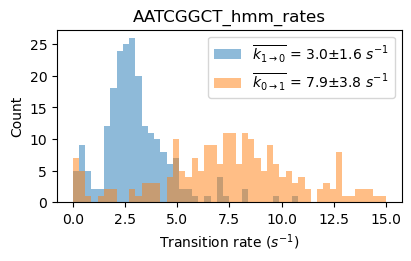

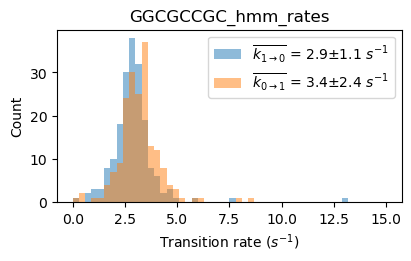

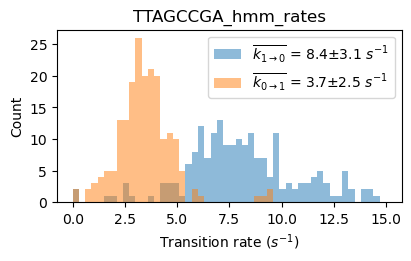

In [38]:
files_HJ137.plot_hmm_rates()